# Benign and malignant tumor classification
### Introduction
The Wisconsin Breast Cancer dataset was used for this classification study. The creators of the dataset are Dr. William H. Wolberg, W. Nick Street, and Olvi L. Mangasarian of the University of Wisconsin. Complete information of the dataset can be found here: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29. The dataset was donated for public use in 1995. 

To obtain the data, the authors analyzed digitalized images of a fine needle aspirate (FNA) from breast masses. With these images and their corresponding diagnoses (benign vs malignant), the authors then extracted the following data for individual cancerous cells that correspond to the columns of the dataset: 

1) ID number

2) Diagnosis (M = malignant, B = benign)

3-32) Ten real-valued features are computed for each cell nucleus:

	a) radius (mean of distances from center to points on the perimeter)
	b) texture (standard deviation of gray-scale values)
	c) perimeter
	d) area
	e) smoothness (local variation in radius lengths)
	f) compactness (perimeter^2 / area - 1.0)
	g) concavity (severity of concave portions of the contour)
	h) concave points (number of concave portions of the contour)
	i) symmetry 
	j) fractal dimension ("coastline approximation" - 1)

The mean, standard error, and "worst" or largest (mean of the three
largest values) of these features were computed for each image,
resulting in 30 features.  For instance, column 3 is Mean Radius, column
13 is Radius SE, column 23 is Worst Radius.

Given all the features above, I built a random forest model for malignant vs benign tumor prediction, using all of the features available. Briefly, a random forest model is an ensemble variation of the decision tree classifier, where many trees are built and contribute to the final decision. Each of these trees contain random features from a random subset of samples, with the idea that many uncorrelated (random) models will outperform any one individual decision tree. Similar to a standard decision tree classifier, many hyperparameters are available for tuning with a random forest classifier. I optimized some of them here.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np

### Data Cleaning
To load the data, I first downloaded the wdbc.data dataset available here: https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/. Using a text editor, I labeled each column with their repective cellular image metric, such as radius, texture, etc. With that, I used Google Drive to import my data into this notebook, with the dataframe saved as cancer_data. I then used sklearn's label encoder to covert malignant and benign labels into 1 and 0 respectively.

In [ ]:
cancer_data = pd.read_csv(
 "/wdbc.data", index_col =[0], 
)

encoder = LabelEncoder()
encoder.fit(cancer_data.diagnosis)
cancer_data["encoding"] = encoder.transform(cancer_data.diagnosis) # Malignant(M) is 1, Benign(B) is 0

In [ ]:
cancer_data

,diagnosis,radius,texture,perimeter,area,smoothness,compactness,concavity,concave points,symmetry,fractal dimension,radius SE,texture SE,perimeter SE,area SE,smoothness SE,compactness SE,concavity SE,concave points SE,symmetry SE,fractal dimension SE,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,encoding
ID number,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,1
842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,1
84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,1
84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,1
84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,1.1760,1.2560,7.673,158.70,0.010300,0.02891,0.05198,0.02454,0.01114,0.004239,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,1
926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,0.7655,2.4630,5.203,99.04,0.005769,0.02423,0.03950,0.01678,0.01898,0.002498,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,1
926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,0.4564,1.0750,3.425,48.55,0.005903,0.03731,0.04730,0.01557,0.01318,0.003892,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,1


In [ ]:
# extract feature names
features = np.array(cancer_data.columns)[1:len(cancer_data.columns)-1]
features

array(['radius', 'texture', 'perimeter', 'area', 'smoothness',
       'compactness', 'concavity', 'concave points', ' symmetry',
       ' fractal dimension', 'radius SE', 'texture SE', 'perimeter SE',
       'area SE', 'smoothness SE', 'compactness SE', 'concavity SE',
       'concave points SE', ' symmetry SE', ' fractal dimension SE',
       'worst radius', ' worst texture', ' worst perimeter',
       ' worst area', ' worst smoothness', ' worst compactness',
       ' worst concavity', ' worst concave points', ' worst symmetry',
       ' worst fractal dimension'], dtype=object)

### Model Training and Hyperparameter Optimization
I utilized sklearn's RandomizedSearchCV to try several combinations of values for different parameters. As opposed to trying every single combination of hyperparameter values like GridSearchCV, RandomizedSearchCV uses a cross-validation based approach to try a subset of all possibilities, allowing for faster computaiton.

In [ ]:
# train test split, train size 80% test size 20%, stratified
train_data, test_data = train_test_split(cancer_data, train_size = 0.8, stratify = cancer_data['encoding'], random_state=1)

In [ ]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

# Use randomized search cv to test a range of paramters arbitrarily inputted 
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [100, 200]
max_features = ['auto', 'sqrt']
max_depth = [5, 10, 30]
min_samples_split = [2, 10, 15]
min_samples_leaf = [2, 5, 10]
grid_param = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

# Construct and fit model
rf_model = RandomizedSearchCV(estimator = RandomForestClassifier(), param_distributions = grid_param, 
                              n_iter = 50, random_state=1, n_jobs = -1)
rf_model.fit(train_data[features], train_data['encoding'])
print(rf_model.best_params_)

{'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 10}


In [ ]:
# Use best params to make new model
optimized_forest_model = RandomForestClassifier(n_estimators=200, max_depth=5, min_samples_leaf=2, min_samples_split=15, 
                                                max_features = "sqrt",random_state=1)
optimized_forest_model.fit(train_data[features], train_data['encoding'])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=15,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

### Model Evaluation

In [ ]:
# Model evaluation
# Train and test accuracy with optimized decision tree
opt_train_predictions = optimized_forest_model.predict(train_data[features])
opt_train_accuracy = sum(train_data['encoding'] == opt_train_predictions)/len(opt_train_predictions)
print("Optimized train accuracy:", opt_train_accuracy)
opt_test_predictions = optimized_forest_model.predict(test_data[features])
opt_test_accuracy = sum(test_data['encoding'] == opt_test_predictions)/len(opt_test_predictions)
print("Optimized test accuracy:", opt_test_accuracy)

Optimized train accuracy: 0.9802197802197802
Optimized test accuracy: 0.9473684210526315


In [ ]:
# Confusion matrix
import seaborn as sns

def plot_confusion_matrix(MM, BM, MB, BB):
    """
    Plots a confusion matrix using the values 
       MM - actual malignant predicted malignant
       BM - actual benign predicted malignant
       MB - actual malignant predicted benign
       BB - actual benign predicted benign
    """
    data = np.matrix([[MM, BM], [MB, BB]])

    sns.heatmap(data,annot=True,xticklabels=['Actual malignant', 'Actual benign'] 
              ,yticklabels=['Pred. malignant', 'Pred. benign'])

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


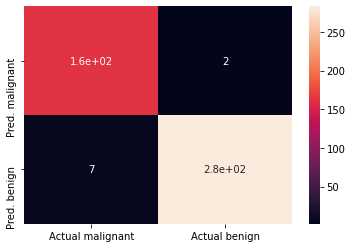

In [ ]:
# train eval

MM = 0 # actual AML predicted AML
BM = 0 # actual ALL predicted AML
MB = 0 # actual AML predicted ALL
BB = 0 # actual ALL predicted ALL
index = 0
for prediction in opt_train_predictions:
  if prediction == 1: # M
    if train_data.iloc[index].encoding == 1:
      MM += 1
    else:
      BM += 1
  else: # predicted B
    if train_data.iloc[index].encoding == 1:
      MB += 1
    else:
      BB += 1
  index += 1
plot_confusion_matrix(MM, BM, MB, BB)

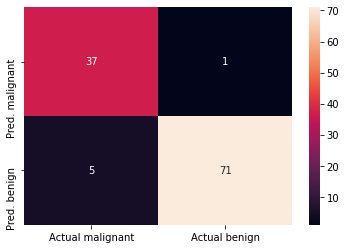

In [ ]:
# test eval

MM = 0 # actual AML predicted AML
BM = 0 # actual ALL predicted AML
MB = 0 # actual AML predicted ALL
BB = 0 # actual ALL predicted ALL
index = 0
for prediction in opt_test_predictions:
  if prediction == 1: # M
    if test_data.iloc[index].encoding == 1:
      MM += 1
    else:
      BM += 1
  else: # predicted B
    if test_data.iloc[index].encoding == 1:
      MB += 1
    else:
      BB += 1
  index += 1
plot_confusion_matrix(MM, BM, MB, BB)

### Discussion
The random forest classifier with semi-optimized parameters performed well, with high accuracies for both the train and test data. The train accuracy was 0.98 and the test accuracy was 0.95. While not statistically significant given the sample size, there seems to be a slightly higher error in which the model predicts the cancer to be benign with the cancer being malignant in reality. This is an obvious area for future improvement and minimization, as this type of error can prevent patients from getting the treatment they need.

To improve the overall accuracy, I hypothesize that a model that selects important features, such as ridge or lasso regression, can potentially be used with this dataset of 30 features. For datasets with many features, it is common for models to overfit, or use redundant, overlapping/correlated features. Using lasso or ridge normalization, some of these features can be filtered out, leaving behind the most predictive features in the model. In addition, these methods would allow for better interpretability, unlike a random forest model where it is difficult to tell which features contributed to the final decision.

Since this model was trained only on a dataset localized in Wisconsin, more data need to be inputted for the model to scale and generalize. This type of random forest classifier can be powerful in providing physician and oncologists a second opinion on cancer diagnosis based on cell images. If more patient information are incorporated, the model can achieve higher prediction accuracy in cancer diagnosis applications.